In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import mpld3
from functions import dataToTimeSeries

In [32]:
df = pd.read_excel('./dataframes/all_downtimes.xlsx')
df.head()

,LineID,LineDescription,ResourceID,ResourceNameNeu,ResourceName,DisplayOrder,StopGroupID,StopGroupNameNeu,StopGroupName,StopGroupDisabled,...,StopReasonDisabled,StopReasonReportExclude,PEStopGroupID,PEStopGroupNameNeu,PEStopGroupName,HarmoniseSourceID,FromTime,ToTime,DurationSec,Comment
0,49001003,GLA 03,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2020-01-06 10:00:00.000,2020-01-06 11:00:00.000,3600,NaN
1,49001003,GLA 03,2,Melting stop,Schmelz Stop,2,2,Grp. Melt Stop,Grp. Schmelz Stop,0,...,0,0,4.0,Group 4 (Melt stop cupola),Group 4 (Melt stop cupola),1002,2020-01-06 10:00:00.000,2020-01-06 11:00:00.000,3600,NaN
2,49001003,GLA 03,3,Planned stop,Geplanter Stop,3,3,Grp. Plan. Stop,Grp. geplanlter stop,0,...,0,0,2.0,Group 2 (Holidays / overcapacity),Group 2 (Holidays / overcapacity),1003,2020-01-06 10:00:00.000,2020-01-06 11:00:00.000,3600,NaN
3,49001001,GLA 01,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2020-01-06 13:30:00.000,2020-01-06 13:35:00.000,300,kein Harz
4,49001003,GLA 03,1,Production stop,Produktion Stop,1,1,Grp. Prod. Stop,Grp. Prod. Stop,0,...,0,0,6.0,Group 6 (Stop for technical),Group 6 (Stop for technical),1001,2020-01-06 14:53:48.000,2020-01-06 16:22:12.000,5304,Rückschlagventil gewechselt


In [33]:
df.shape

(4869, 23)

In [34]:
df['ResourceNameNeu'].unique()

array(['Production stop', 'Melting stop', 'Planned stop', 'Filter Bypass',
       'Emergency Cimney'], dtype=object)

In [35]:
df = df[(df['LineDescription']=='GLA 03') & (df['ResourceNameNeu'] == 'Production stop')]
df.shape

(1808, 23)

In [36]:
df['FromTime'] = pd.to_datetime(df['FromTime'])

In [37]:
df['year'] = df['FromTime'].dt.year

In [38]:
grouped_year = df.groupby('year')['year'].count()

In [39]:
grouped_year = pd.DataFrame(grouped_year)

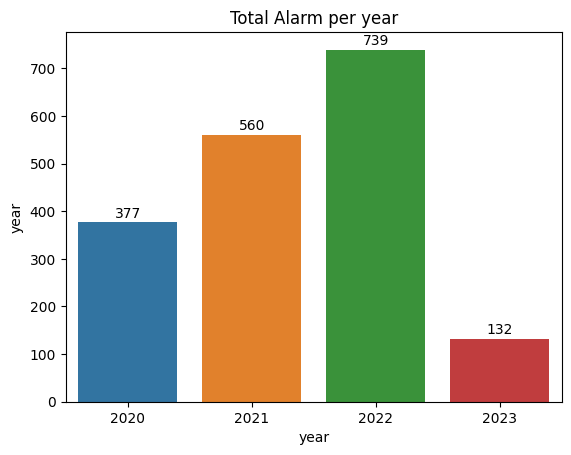

In [40]:
ax = sns.barplot(data=grouped_year, x=grouped_year.index, y='year')
ax.set_title("Total Alarm per year")

for i, v in enumerate(grouped_year['year']):
    ax.text(i, v+10, str(v), ha='center', fontsize=10)

plt.show()

In [41]:
data = df[['FromTime', 'ToTime']]

In [42]:
data_save = data.copy()

In [59]:
data['FromTime'] = pd.to_datetime(data['FromTime']).dt.floor('min')
data['ToTime'] = pd.to_datetime(data['ToTime']).dt.floor('min')
data.set_index('FromTime', inplace=True)
data['trigger'] = 1
data.head()

,ToTime,trigger
FromTime,,
2020-01-06 10:00:00,2020-01-06 11:00:00,1
2020-01-06 14:53:00,2020-01-06 16:22:00,1
2020-01-06 17:48:00,2020-01-06 18:25:00,1
2020-01-08 00:46:00,2020-01-08 01:32:00,1
2020-01-08 21:59:00,2020-01-08 22:22:00,1


In [60]:
df_changed = data.resample('1T').asfreq()
df_changed.head()

,ToTime,trigger
FromTime,,
2020-01-06 10:00:00,2020-01-06 11:00:00,1.0
2020-01-06 10:01:00,NaT,NaN
2020-01-06 10:02:00,NaT,NaN
2020-01-06 10:03:00,NaT,NaN
2020-01-06 10:04:00,NaT,NaN


In [63]:
df_changed['ToTime'] = df_changed['ToTime'].fillna(method='ffill')
df_changed['trigger'] = df_changed['trigger'].fillna(0)

In [64]:
df_changed['downtime'] = df_changed.apply(lambda row: 1 if row['ToTime'] > row.name else 0, axis=1)

<Axes: xlabel='FromTime'>

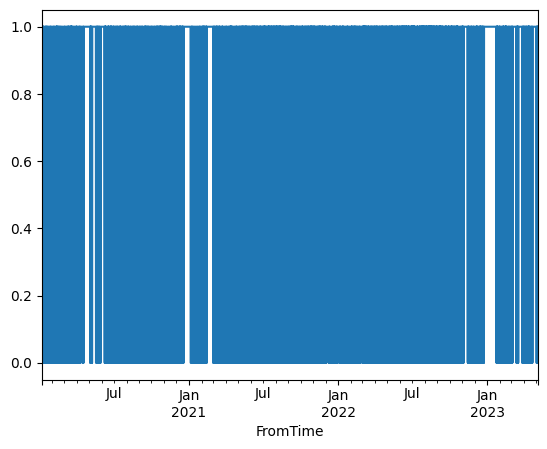

In [65]:
df_changed.downtime.plot()

In [66]:
df_changed

,ToTime,trigger,downtime
FromTime,,,
2020-01-06 10:00:00,2020-01-06 11:00:00,1.0,1
2020-01-06 10:01:00,2020-01-06 11:00:00,0.0,1
2020-01-06 10:02:00,2020-01-06 11:00:00,0.0,1
2020-01-06 10:03:00,2020-01-06 11:00:00,0.0,1
2020-01-06 10:04:00,2020-01-06 11:00:00,0.0,1
...,...,...,...
2023-05-04 09:21:00,2023-05-03 10:31:00,0.0,0
2023-05-04 09:22:00,2023-05-03 10:31:00,0.0,0
2023-05-04 09:23:00,2023-05-03 10:31:00,0.0,0


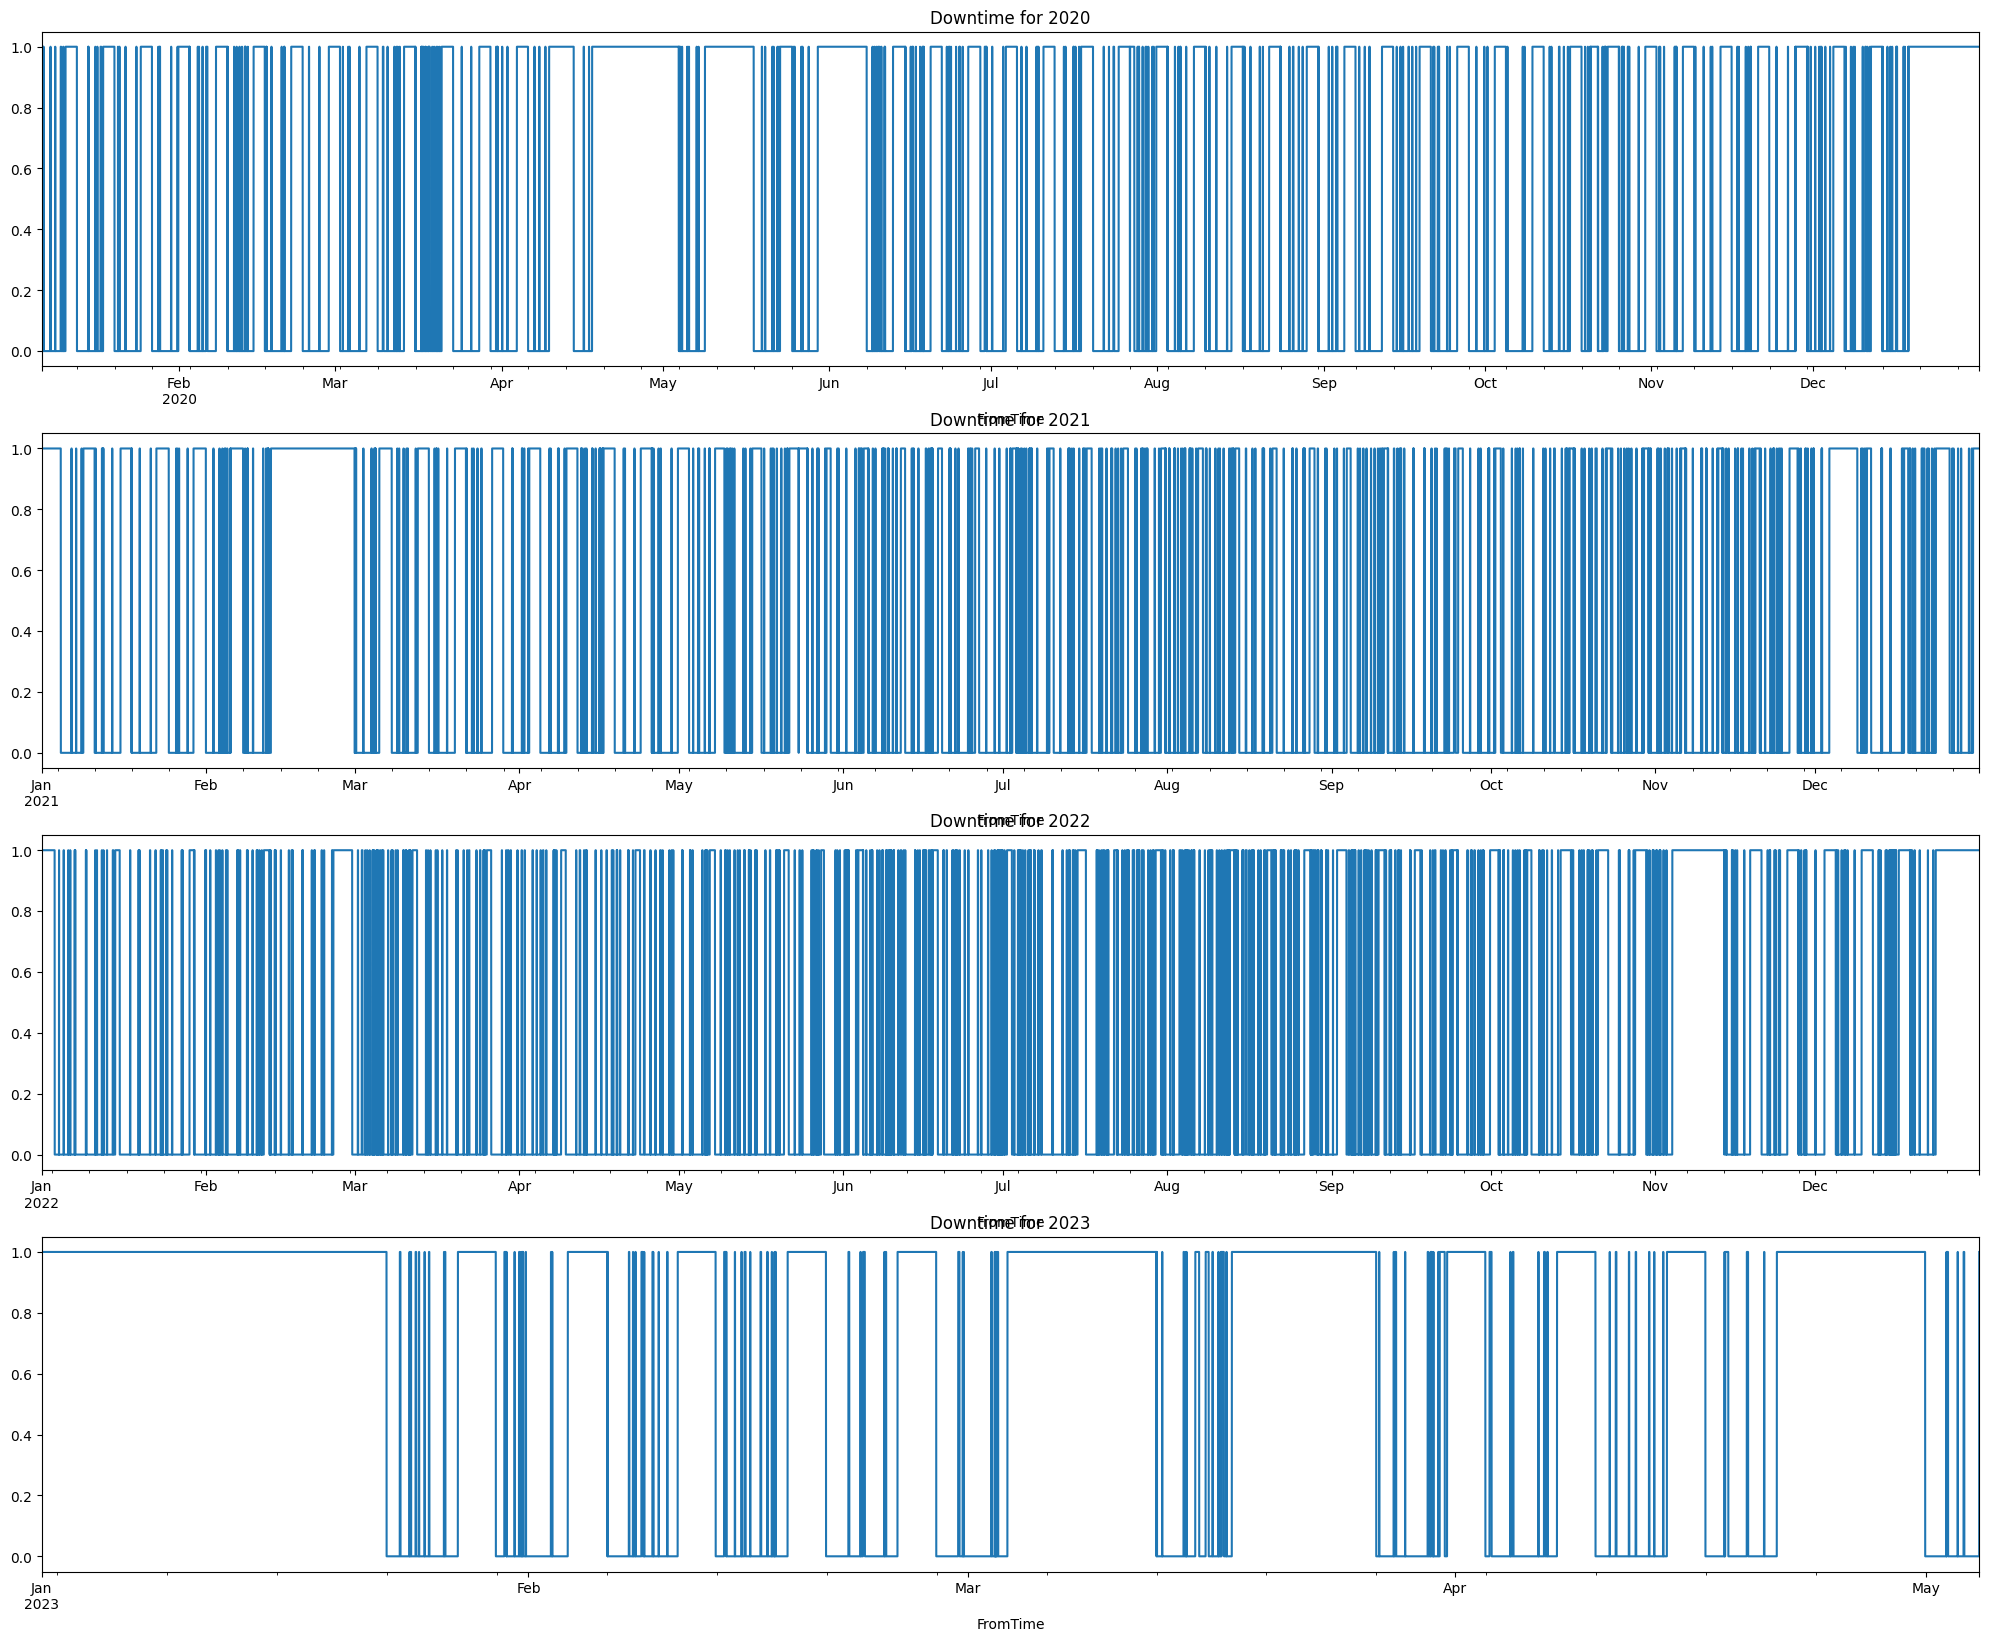

In [77]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(25,20))


df_changed[df_changed.index.year == 2020]['downtime'].plot(ax=ax1)
df_changed[df_changed.index.year == 2021]['downtime'].plot(ax=ax2)
df_changed[df_changed.index.year == 2022]['downtime'].plot(ax=ax3)
df_changed[df_changed.index.year == 2023]['downtime'].plot(ax=ax4)

ax1.set_title('Downtime for 2020')
ax2.set_title('Downtime for 2021')
ax3.set_title('Downtime for 2022')
ax4.set_title('Downtime for 2023')

plt.show()


plt.show()

<Axes: ylabel='downtime'>

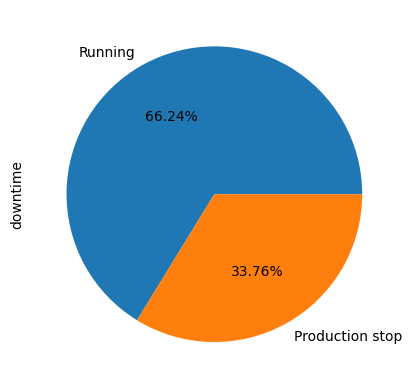

In [78]:
counts = df_changed.downtime.value_counts()
labels = ['Running', 'Production stop']
counts.plot.pie(autopct='%.2f%%', labels = labels)

In [19]:
df_downtimes.to_csv('downtimes_2022.csv')

In [17]:
df_changed.to_csv('./dataframes/downtimes_2022_ms.csv')

In [15]:
df_changed.to_csv('./dataframes/downtime_2023.csv')

In [79]:
df_changed.to_csv('all_downtimes_processed.csv')